# Neural Classification

In [141]:
### Imports
import sklearn
from sklearn.datasets import make_circles,make_blobs
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import requests
from pathlib import Path

import torchmetrics

### 1. Getting Data

In [46]:
# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,random_state=42, noise=0.03)
len(X), len(y)

(1000, 1000)

In [47]:
print(f"First 5 samples of X: \n {X[:5]}")
print(f"First 5 samples of y: \n{y[:5]}")

First 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
[1 1 1 1 0]


In [5]:
# Make dataframe
circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "Labels": y
})

circles

,X1,X2,Labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


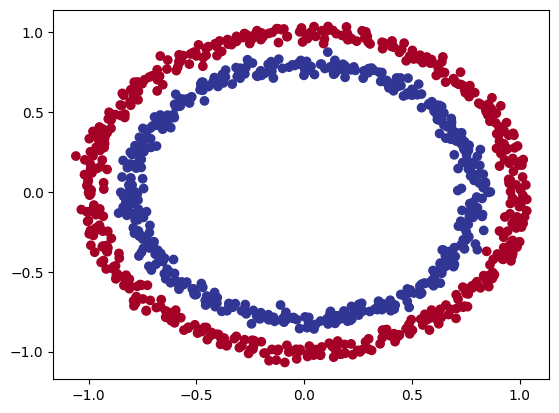

In [6]:
# PLot the data
plt.scatter(x = X[:,0], y = X[:,1], c = y,cmap=plt.cm.RdYlBu)

### 1.1 Input and Output Shapes

In [7]:
X.shape, y.shape, type(X), type(y), X.dtype, y.dtype

((1000, 2),
 (1000,),
 numpy.ndarray,
 numpy.ndarray,
 dtype('float64'),
 dtype('int64'))

### 1.2 Convert Data to tensors and split data
Default `dtype` for numpy is `float64`  
Deafualt `dtype` for torch is `float64`  
Therefore there is need to convert to torch default dtype when converting from `ndarray` to `torch tensors`

In [48]:
## COnvert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [49]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [50]:
### Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [51]:
X_train.shape

torch.Size([800, 2])

### 2. Building Model

In [12]:
## Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [13]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # create 2 layers
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)
        
    def forward(self, x):
        # output = self.layer_1(x)
        # output = self.layer_2(output)
        return self.layer_2(self.layer_1(x))
    
### Create Instance of the Model and move to device
model_0 = CircleModel().to(device)
print(model_0)
# check which device model is on
print(f"Model is Loaded to: {next(model_0.parameters()).device}")

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)
Model is Loaded to: cpu


In [14]:
### Creating Model using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5 ,out_features=1)
).to(device)

print(model_0)
# check which device model is on
print(f"Model is Loaded to: {next(model_0.parameters()).device}")

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)
Model is Loaded to: cpu


In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5864, -0.2372],
                      [-0.5861, -0.1595],
                      [ 0.3271,  0.4814],
                      [-0.5257, -0.5636],
                      [ 0.6800, -0.4687]])),
             ('0.bias', tensor([ 0.3121,  0.1496,  0.0739, -0.0352,  0.5040])),
             ('1.weight',
              tensor([[ 0.1299, -0.1118, -0.4242, -0.3977,  0.2201]])),
             ('1.bias', tensor([0.1755]))])

### 2.1 Loss Function and Optimizer  
**Loss Functions**  
Regression uses Mean Absolute Error (MAP) or Mean Square Error (MSE).  
Classification uses Binary Cross Entropy or Categorical Cross Entropy for multi-class classification


In [16]:
### Loss function
loss_fn  = nn.BCEWithLogitsLoss() # Sigmoid function built-in

## Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)



In [17]:
### Evaluation Metric
### Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_pred,y_true).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

### 3.1 Train Model


### Raw Logits => Prediction probabilities => Predicted Labels

**Logits** are the raw model output.  
Convert **Logits** to prediciton probabilities by passing through activation function (`sigmoid or softmax`)  
Convert predicted probabilities to predicted labels by taking `argmax` or `rounding them`

In [18]:
## Forward pass on the test data to get logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
print(f"Logits: \n {y_logits} \n")

## Applying sigmoid to the logits
y_pred_proba = torch.sigmoid(y_logits)
print(f"Predicted Probabilities: \n  {y_pred_proba} \n")

## Get class labels
y_pred = torch.round(y_pred_proba)
print(f"Class Labels: \n {y_pred} \n")

## In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

## Check for equality
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))

## Remove extra dimensions

y_pred.squeeze()


Logits: 
 tensor([[0.0915],
        [0.2061],
        [0.0689],
        [0.0967],
        [0.5099]]) 

Predicted Probabilities: 
  tensor([[0.5229],
        [0.5513],
        [0.5172],
        [0.5242],
        [0.6248]]) 

Class Labels: 
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]) 

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### Building Training and Testing Loop

In [19]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)
    
epochs = 100

# Transfer Data and Model to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_0 = model_0.to(device)

for epoch in range(epochs):
    #### TRAINING
    model_0.train()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # forward pass
    logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(logits))
    
    # compute loss and perform back propagation
    loss = loss_fn(logits, y_train) ## BCEWIthLogitsLoss expects raw logits as input
    
    # accuracy    
    accuracy = accuracy_fn(y_train,y_preds)
    loss.backward()
    # adjust learning weights
    optimizer.step()
    
    ### TESTING
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        # compute loss and accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_accuracy = accuracy_fn(y_test,test_preds)
        
    ## Print out 
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {accuracy:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_accuracy:.5f}%")
    
    

Epoch: 0 | Loss: 0.71067 | Acc: 57.25000% | Test Loss: 0.71170 | Test Acc: 54.50000%
Epoch: 10 | Loss: 0.70925 | Acc: 57.12500% | Test Loss: 0.71034 | Test Acc: 54.50000%
Epoch: 20 | Loss: 0.70796 | Acc: 56.37500% | Test Loss: 0.70909 | Test Acc: 53.50000%
Epoch: 30 | Loss: 0.70677 | Acc: 56.12500% | Test Loss: 0.70795 | Test Acc: 52.50000%
Epoch: 40 | Loss: 0.70569 | Acc: 55.87500% | Test Loss: 0.70690 | Test Acc: 53.00000%
Epoch: 50 | Loss: 0.70470 | Acc: 55.00000% | Test Loss: 0.70595 | Test Acc: 52.50000%
Epoch: 60 | Loss: 0.70380 | Acc: 54.37500% | Test Loss: 0.70507 | Test Acc: 53.00000%
Epoch: 70 | Loss: 0.70297 | Acc: 54.37500% | Test Loss: 0.70427 | Test Acc: 52.50000%
Epoch: 80 | Loss: 0.70221 | Acc: 53.87500% | Test Loss: 0.70353 | Test Acc: 52.50000%
Epoch: 90 | Loss: 0.70152 | Acc: 53.87500% | Test Loss: 0.70286 | Test Acc: 53.00000%


### 4. Make Predictions and Evaluate Model 


In [24]:
### Download Helper functions

if Path('helper_functions.py').is_file:
    print('helper_functions.py already exists, skipping download')
    
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py')
    with open('helper_functions.py','wb') as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


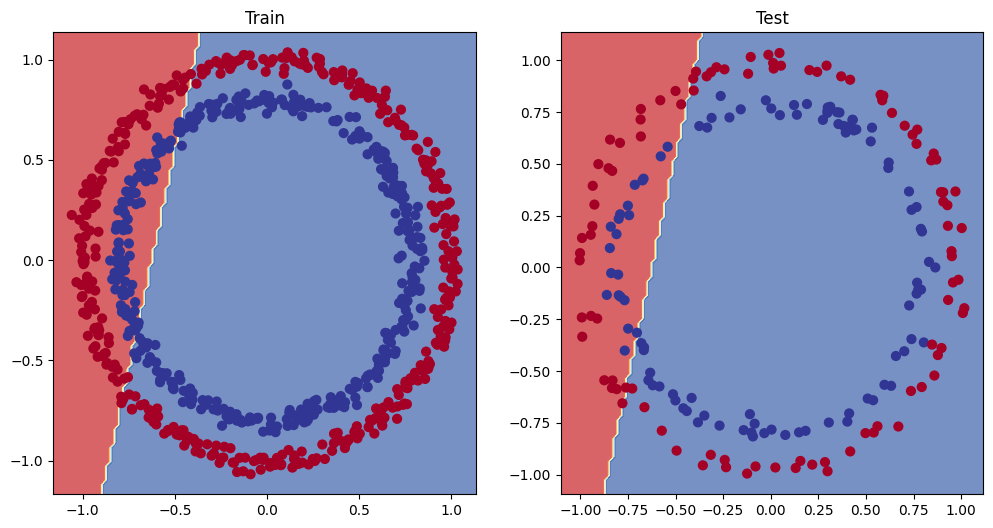

In [30]:
### PLot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)


### 5. Improving Model Performance
* Addd more layers
* Add more hidden units
* More Epochs
* Change activation functions
* Change learning rate
* change loss function

In [35]:
class CircleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        
    def forward(self,x):            
            return self.layer_3(self.layer_2(self.layer_1(x)))
        
## Create instance of model
model_1 = CircleModelv1().to(device)
model_1

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
### Loss Function
loss_fn = nn.BCEWithLogitsLoss()

### optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [40]:

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)
    

## move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):
    model_1.train()
    
    # zero the gradients
    optimizer.zero_grad()
    
    # forward pass
    logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(logits))
    
    # compute loss and accuracy
    loss = loss_fn(logits,y_train)
    acc = accuracy_fn(y_train,y_preds)
    loss.backward()
    
    # update weights
    optimizer.step()
    
    
    #### EVALUATION
    model_1.eval()
    with torch.inference_mode():
        logits = model_1(X_test).squeeze()
        test_loss = loss_fn(logits,y_test)
        
        test_preds  = torch.round(torch.sigmoid(logits))
        test_acc = accuracy_fn(y_test,test_preds)
     ## Print out 
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {accuracy:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_accuracy:.5f}%")

Epoch: 0 | Loss: 0.69384 | Acc: 53.25000% | Test Loss: 0.69231 | Test Acc: 53.50000%
Epoch: 100 | Loss: 0.69367 | Acc: 53.25000% | Test Loss: 0.69236 | Test Acc: 53.50000%
Epoch: 200 | Loss: 0.69355 | Acc: 53.25000% | Test Loss: 0.69243 | Test Acc: 53.50000%
Epoch: 300 | Loss: 0.69346 | Acc: 53.25000% | Test Loss: 0.69251 | Test Acc: 53.50000%
Epoch: 400 | Loss: 0.69339 | Acc: 53.25000% | Test Loss: 0.69259 | Test Acc: 53.50000%
Epoch: 500 | Loss: 0.69333 | Acc: 53.25000% | Test Loss: 0.69266 | Test Acc: 53.50000%
Epoch: 600 | Loss: 0.69329 | Acc: 53.25000% | Test Loss: 0.69274 | Test Acc: 53.50000%
Epoch: 700 | Loss: 0.69326 | Acc: 53.25000% | Test Loss: 0.69282 | Test Acc: 53.50000%
Epoch: 800 | Loss: 0.69323 | Acc: 53.25000% | Test Loss: 0.69289 | Test Acc: 53.50000%
Epoch: 900 | Loss: 0.69320 | Acc: 53.25000% | Test Loss: 0.69296 | Test Acc: 53.50000%


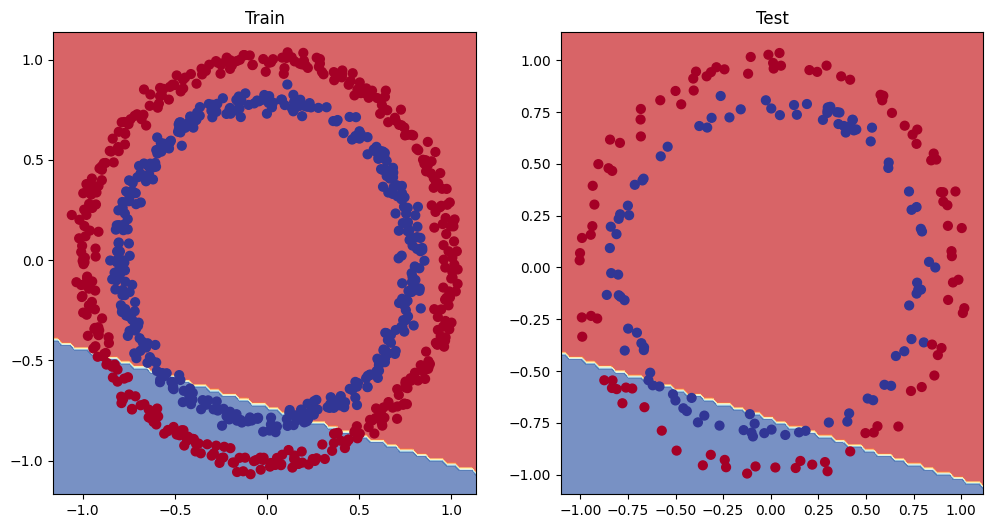

In [41]:
### PLot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)


### 6. Introducing Non-Linearity

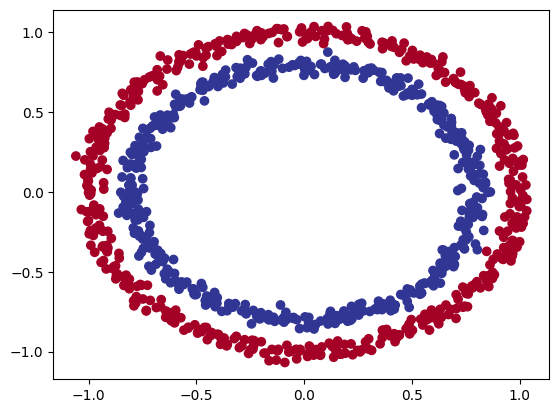

In [64]:
# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,random_state=42, noise=0.03)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

### Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
len(X_train), len(X_test), len(y_train), len(y_test)

# Plot the data
plt.scatter(x = X[:,0], y = X[:,1], c = y,cmap=plt.cm.RdYlBu)

In [77]:
#### Build mode with Non-Linear activation function

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        ## Layer_3 -> Relu -> Layer_2 -> Relu -> Layer_1
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
### Create Model and send to device
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [78]:
### Loss Function
loss_fn = nn.BCEWithLogitsLoss()

## optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)

In [79]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)
    
epochs = 1000

## move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ####TRAINING
    model_2.train()
    
    optimizer.zero_grad()
    logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(logits))
    loss = loss_fn(logits,y_train)
    acc = accuracy_fn(y_train,y_pred)
    loss.backward()
    optimizer.step()
    
    ### TESTING
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_preds)
     ## Print out 
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00000% | Test Loss: 0.69319 | Test Acc: 50.00000%
Epoch: 100 | Loss: 0.69115 | Acc: 52.87500% | Test Loss: 0.69102 | Test Acc: 52.50000%
Epoch: 200 | Loss: 0.68977 | Acc: 53.37500% | Test Loss: 0.68940 | Test Acc: 55.00000%
Epoch: 300 | Loss: 0.68795 | Acc: 53.00000% | Test Loss: 0.68723 | Test Acc: 56.00000%
Epoch: 400 | Loss: 0.68517 | Acc: 52.75000% | Test Loss: 0.68411 | Test Acc: 56.50000%
Epoch: 500 | Loss: 0.68102 | Acc: 52.75000% | Test Loss: 0.67941 | Test Acc: 56.50000%
Epoch: 600 | Loss: 0.67515 | Acc: 54.50000% | Test Loss: 0.67285 | Test Acc: 56.00000%
Epoch: 700 | Loss: 0.66659 | Acc: 58.37500% | Test Loss: 0.66322 | Test Acc: 59.00000%
Epoch: 800 | Loss: 0.65160 | Acc: 64.00000% | Test Loss: 0.64757 | Test Acc: 67.50000%
Epoch: 900 | Loss: 0.62362 | Acc: 74.00000% | Test Loss: 0.62145 | Test Acc: 79.00000%


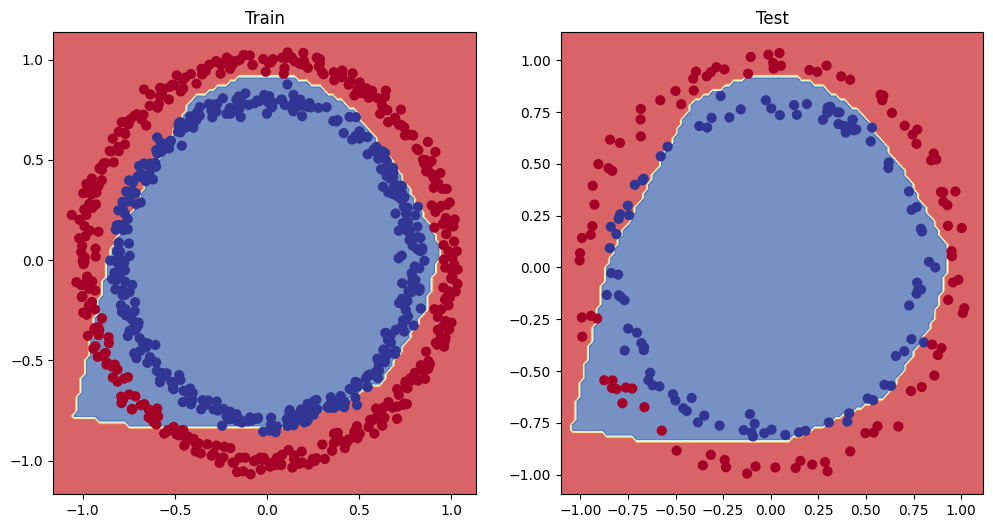

In [80]:
### PLot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2,X_test,y_test)


### 7. Putting it all together with Multi-class Classification Problem

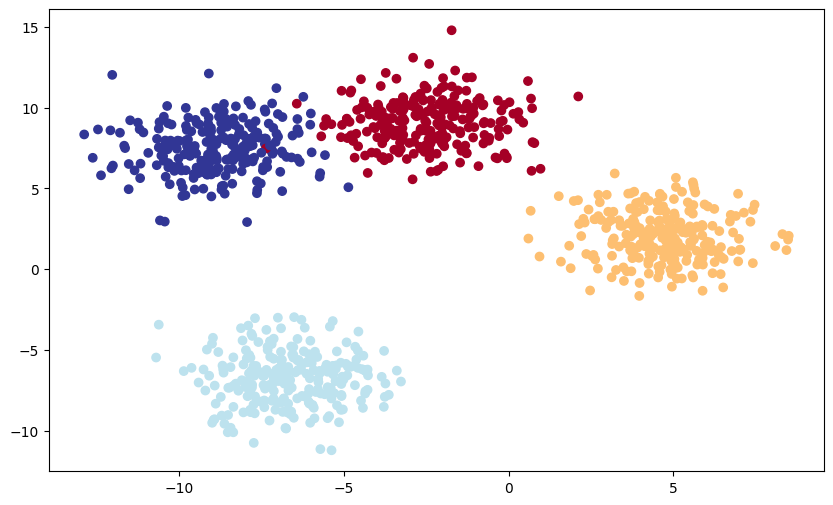

In [125]:
## We shall be using the Make_blobs from sklearn

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

## Create multi-class dataset
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)

# turn data to tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


# Split Data into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,random_state=RANDOM_SEED,test_size=0.2,shuffle=True)


# Plot the Data
plt.figure(figsize=(10,6))
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

### 7.1 Building Multi-class classification model in Pytorch


In [135]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
## Build Model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model
        Args:
            input_features (int): Number of input features to the model
            output_features (_type_): Number of output features (number of classses) to the model
            hidden_units (int, optional): Number of hidden units between layers. Defaults to 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features),
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
    
### Create instance of Blob Model
model_3 = BlobModel(input_features=2, output_features=4,hidden_units=8).to(device)
model_3



BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [136]:
### Loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### Move data to device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)


### 7.2 Look at Model Output

In [137]:
model_3.eval()
with torch.inference_mode():
    logits = model_3(X_blob_test)
print(f'Logits: \n{logits[:5]}\n')

### Convert Logits to probabilities
y_proba = torch.softmax(logits,dim=1)
print(f'Probabilities: \n{y_proba[:5]}\n')

### COnvert probabilities to labels
y_pred = torch.argmax(y_proba,dim=1)
print(f'Predicted Labels: \n{y_pred[:5]}')

Logits: 
tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])

Probabilities: 
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])

Predicted Labels: 
tensor([3, 3, 2, 1, 3])


### 7.3 Training and Testing Loop

In [138]:

epochs = 100
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

### Move data to device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### TRAINING    
    model_3.train()
    optimizer.zero_grad()
    logits = model_3(X_blob_train)
    
    y_pred = torch.softmax(logits,dim=1).argmax(dim=1)  
    #print(logits.shape, y_pred.shape)  
    loss = loss_fn(logits,y_blob_train)
    acc = accuracy_fn(y_blob_train,y_pred)
    loss.backward()
    optimizer.step()
    
    
    #### EVALUATION
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_blob_test)
        test_proba = torch.softmax(test_logits,dim=1)
        test_preds = torch.argmax(test_proba,dim=1)
        acc = accuracy_fn(y_blob_test,test_preds)
        test_loss = loss_fn(test_logits,y_blob_test)
        
    ## Print out 
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%")



Epoch: 0 | Loss: 1.04324 | Acc: 95.50000% | Test Loss: 0.57861 | Test Acc: 86.50000%
Epoch: 10 | Loss: 0.14398 | Acc: 99.00000% | Test Loss: 0.13037 | Test Acc: 86.50000%
Epoch: 20 | Loss: 0.08062 | Acc: 99.50000% | Test Loss: 0.07216 | Test Acc: 86.50000%
Epoch: 30 | Loss: 0.05924 | Acc: 99.50000% | Test Loss: 0.05133 | Test Acc: 86.50000%
Epoch: 40 | Loss: 0.04892 | Acc: 99.50000% | Test Loss: 0.04098 | Test Acc: 86.50000%
Epoch: 50 | Loss: 0.04295 | Acc: 99.50000% | Test Loss: 0.03486 | Test Acc: 86.50000%
Epoch: 60 | Loss: 0.03910 | Acc: 99.50000% | Test Loss: 0.03083 | Test Acc: 86.50000%
Epoch: 70 | Loss: 0.03643 | Acc: 99.50000% | Test Loss: 0.02799 | Test Acc: 86.50000%
Epoch: 80 | Loss: 0.03448 | Acc: 99.50000% | Test Loss: 0.02587 | Test Acc: 86.50000%
Epoch: 90 | Loss: 0.03300 | Acc: 99.50000% | Test Loss: 0.02423 | Test Acc: 86.50000%


### Evaluation Model & Making Predictions

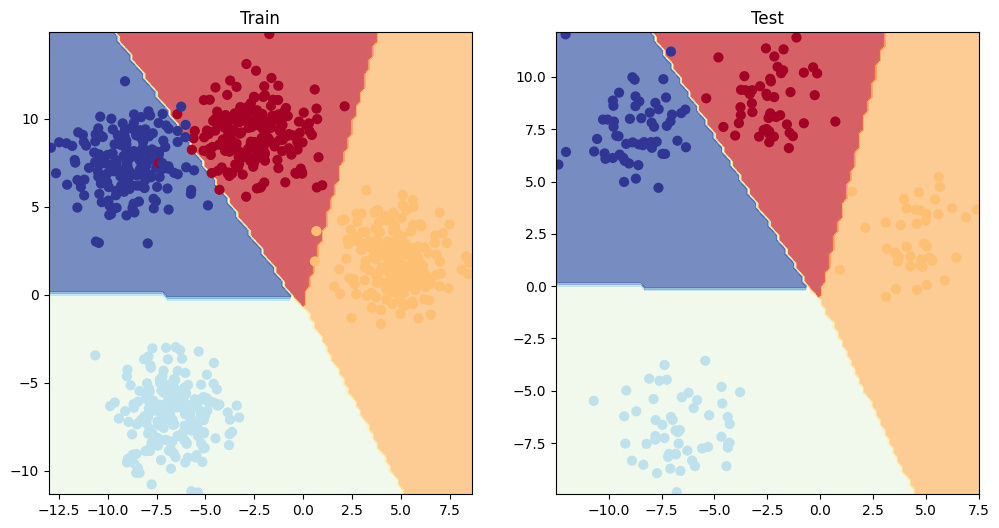

In [139]:
### PLot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3,X_blob_test,y_blob_test)


In [140]:
### Making Predictions

model_3.eval()
with torch.inference_mode():
    logits = model_3(X_blob_test)

### Logits to predicted probabilities
y_proba = torch.softmax(logits,dim=1)

## Probabilities to Labels
predictions = torch.argmax(y_proba,dim=1)
print(f'predictions: \n{predictions}\n')
print(f"True Labels: \n{y_blob_test}")

predictions: 
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

True Labels: 
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3,

### Evalution Metrics

In [145]:
from torchmetrics import Accuracy

accuracy_metric = Accuracy(task='multiclass',num_classes=4).to(device)
accuracy_metric(predictions, y_blob_test)

tensor(0.9950)